In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sns
import pandas as pd
from scipy.stats import gaussian_kde


import time
import os
import re
import itertools
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import autocast
from torch.cuda.amp import GradScaler
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import MinMaxScaler


import optuna

from NF_condGLOW import *

In [2]:
data = pd.read_parquet('/export/home/vgiusepp/MW_MH/data/preprocessing_subsample/preprocess_training_set_Galaxy_name_subsample.parquet')
Galax_name = data['Galaxy_name'].unique()
print('Number of Galaxies:', len(Galax_name))
print('Total log10 Number of stars:', np.log10(len(data)))
print('5 Selected Galaxies:')
Galaxy_to_study = np.random.choice(Galax_name, 5)
data = data[data['Galaxy_name'].isin(Galaxy_to_study)]
for galaxy in Galaxy_to_study:
    print(galaxy, 'Log10 Number of stars:', np.log10(len(data[data['Galaxy_name'] == galaxy])))
print('Total Log10 Number of stars:', np.log10(len(data)))
data = data.sample(frac=1, )

Number of Galaxies: 4476
Total log10 Number of stars: 6.334433845531003
5 Selected Galaxies:
g3.21e11.00416 Log10 Number of stars: 2.6954816764901977
g2.94e10.00400 Log10 Number of stars: 2.6972293427597176
g3.19e10.00880 Log10 Number of stars: 2.69284691927723
g1.23e10.00752 Log10 Number of stars: 2.6232492903979003
g4.86e10.00768 Log10 Number of stars: 2.6981005456233897
Total Log10 Number of stars: 3.381295623003826


In [3]:
# data = pd.read_parquet('/export/home/vgiusepp/MW_MH/data/preprocessing/preprocess_training_set_Galaxy_name.parquet').iloc[:10_000]
# Galaxy_to_study = data['Galaxy_name'].unique()
# for galaxy in Galaxy_to_study:
#     print(galaxy, 'Log10 Number of stars:', np.log10(len(data[data['Galaxy_name'] == galaxy])))
# print('Total Log10 Number of stars:', np.log10(len(data)))

In [4]:
cond_names = list(data.keys()[2:-1])
device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")

# Flow = NF_condGLOW(n_layers=8, dim_notcond=2, dim_cond=12, CL=NSF_CL2, network_args=[128*2, 6, 0.2]).to(device=device)
# losses = []
# training_flow(flow = Flow, 
#                data = data, 
#                cond_names=cond_names, 
#                epochs=100, lr=10**-4, batch_size=512, 
#                loss_saver=losses, checkpoint_dir='/export/home/vgiusepp/MW_MH/tests/architecture/checkpoints/checkpoint_data/', gamma=0.998, optimizer_obj=None)
# Flow.load_state_dict(torch.load('../architecture/checkpoints/checkpoint_data/checkpoint_best.pth'))

Flow = NF_condGLOW(8, dim_notcond=2, dim_cond=12, CL=NSF_CL2, network_args=[512, 6, 0.2]).to(device=device)  # load your model
state_dict = torch.load('/export/home/vgiusepp/MW_MH/tests/architecture/distributed/snapshot.pt')['MODEL_STATE']
Flow.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [5]:
feh_mean, feh_std = np.load('../../data/preprocessing/mean_std_of_feh.npz')['mean'], np.load('../../data/preprocessing/mean_std_of_feh.npz')['std']
ofe_mean, ofe_std = np.load('../../data/preprocessing/mean_std_of_ofe.npz')['mean'], np.load('../../data/preprocessing/mean_std_of_ofe.npz')['std']

data['feh'], data['ofe'] = (data['feh']*feh_std + feh_mean), (data['ofe']*ofe_std + ofe_mean)

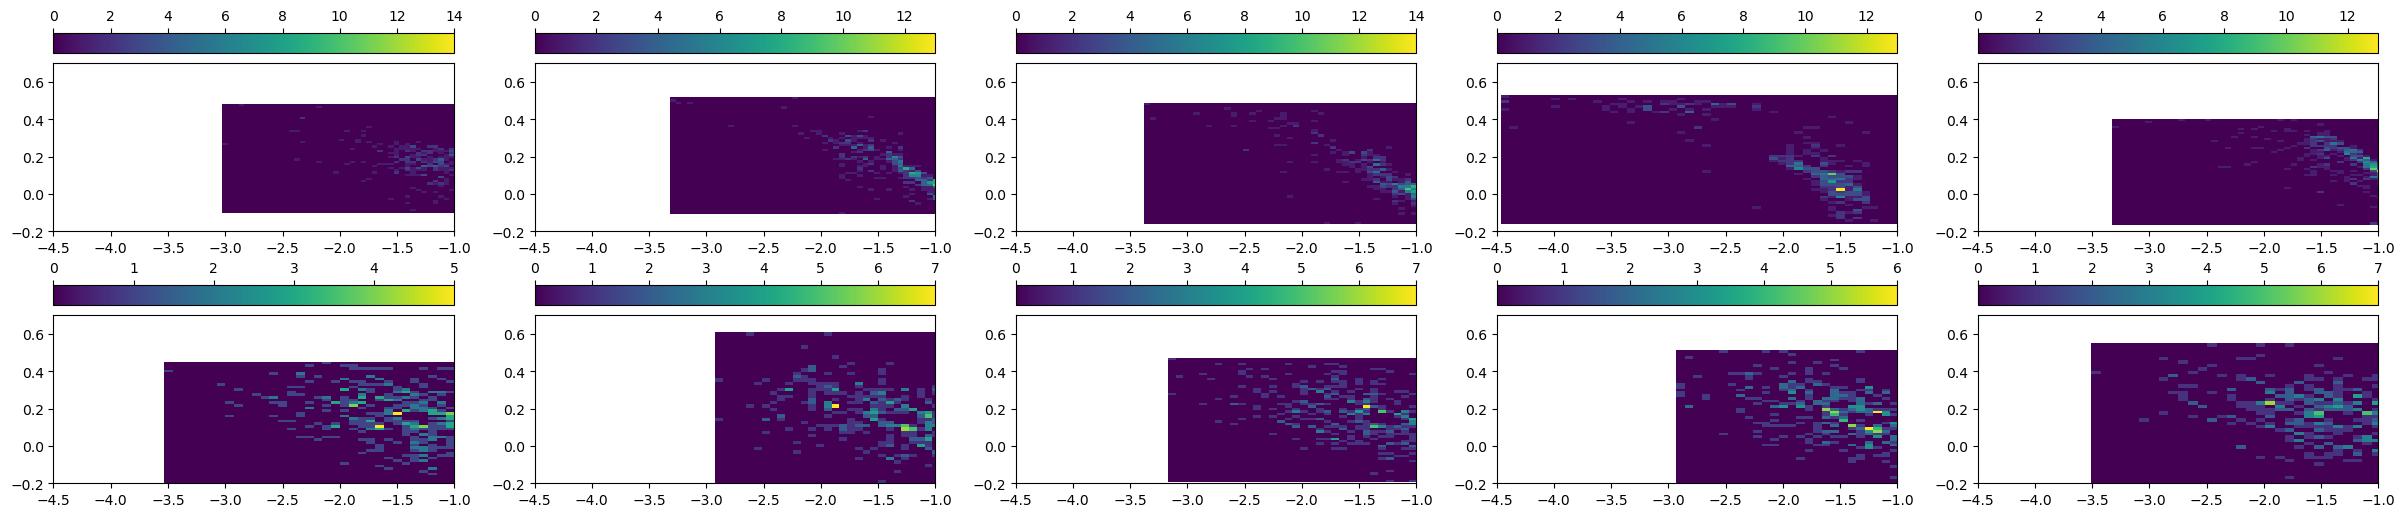

In [13]:
fig = plt.figure(figsize=(30, 6))
bad_column = ['Galaxy_name']
other_columns = data.columns.difference(bad_column, sort=False)

i=0
for galaxy in Galaxy_to_study[:5]:
    i+=1
    ax = fig.add_subplot(2,5,i)
    cax = ax.hist2d(data[data['Galaxy_name']==galaxy]['feh'], data[data['Galaxy_name']==galaxy]['ofe'],
                    bins=50);
    fig.colorbar(cax[3], ax=ax, location='top')
    ax.set_xlim(-4.5, -1.0)
    ax.set_ylim(-0.2, 0.7)
    
    Flow = Flow.to('cpu')
    samples = Flow.sample_Flow(500, data[(data['Galaxy_name']==galaxy)][other_columns].values[0, 2:]) .cpu().detach()
    ax = fig.add_subplot(2, 5, i+5)
    cax = ax.hist2d(samples[:, 0], samples[:, 1], bins=50);
    ax.set_xlim(-4.5, -1.0)
    ax.set_ylim(-0.2, 0.7)
    fig.colorbar(cax[3], ax=ax, location='top')

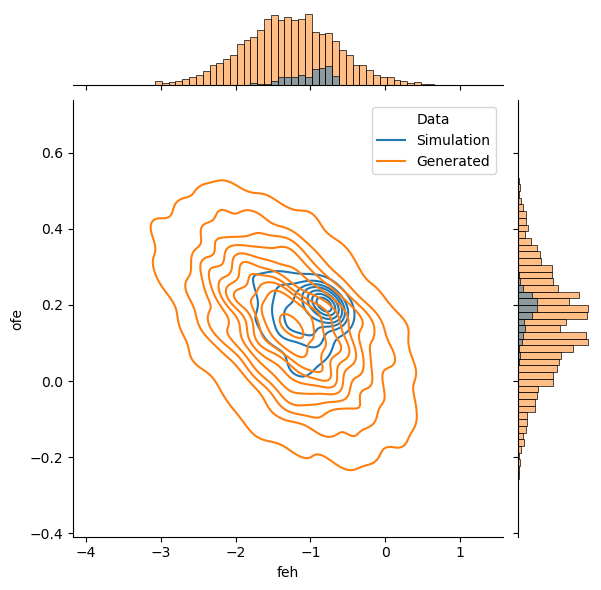

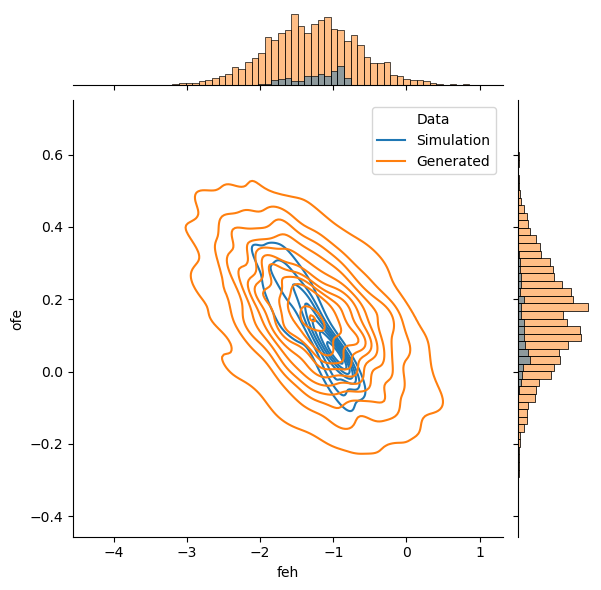

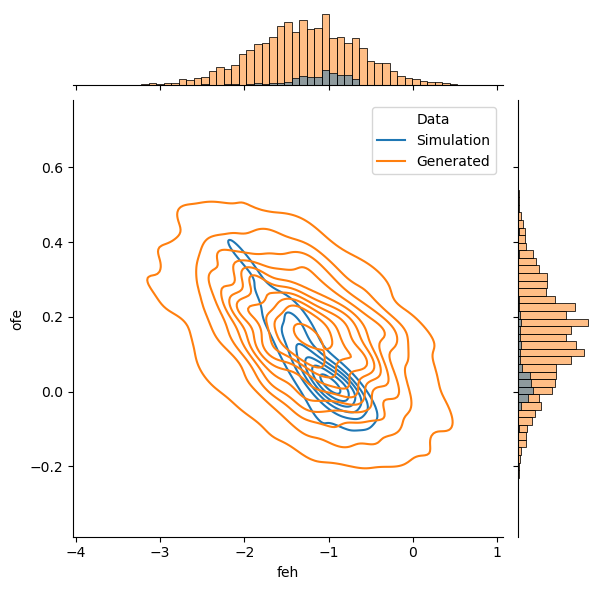

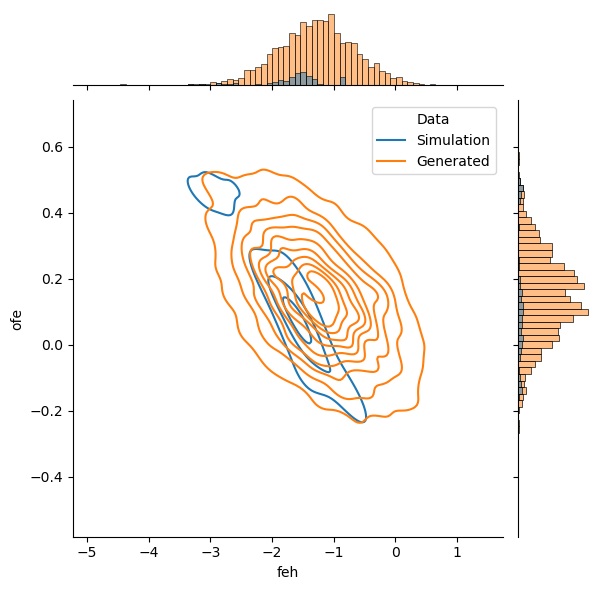

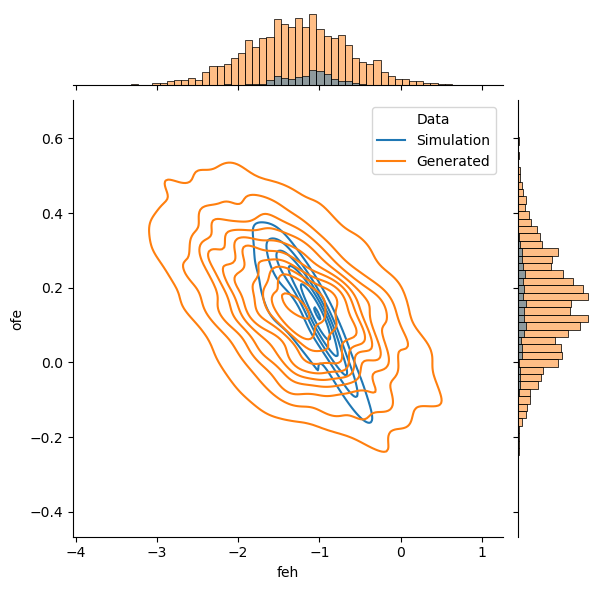

In [51]:
for galaxy in Galaxy_to_study:
    
    true_data = data[data['Galaxy_name']==galaxy]
    generated_data = Flow.sample_Flow(5000, data[data['Galaxy_name']==galaxy][other_columns].values[0,2:]).cpu().detach()
    generated_data = pd.DataFrame(generated_data.numpy(), columns=['feh', 'ofe'])
    
    true_data = true_data[['feh', 'ofe']]
    true_data['Data'] = 'Simulation'
    generated_data['Data'] = 'Generated'
    
    df_joinplot = pd.concat([true_data, generated_data])
    # sns.jointplot(data=df_joinplot, x='feh', y='ofe', hue='Data', kind='hist' , density='true')
    g = sns.JointGrid(data=df_joinplot, x='feh', y='ofe', hue='Data', height=6)
    g = g.plot_joint(sns.kdeplot)
    g = g.plot_marginals(sns.histplot, **{'stat':'probability'})
    plt.show()
    

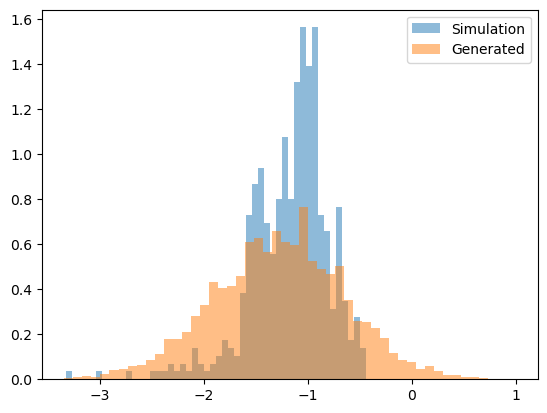

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(true_data['feh'], bins=50, alpha=0.5, label='Simulation', density=True)
ax.hist(generated_data['feh'], bins=50, alpha=0.5, label='Generated', density=True);
ax.legend()

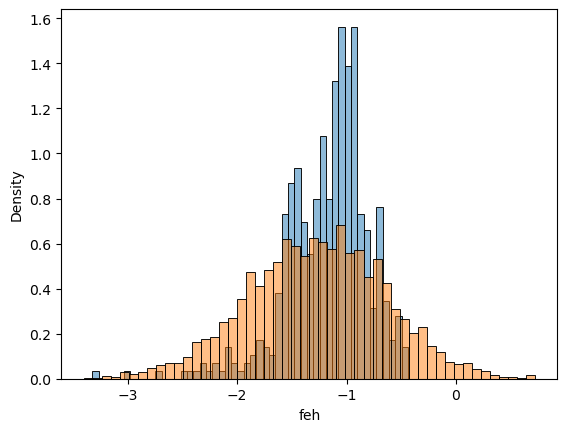

In [42]:
sns.histplot(true_data['feh'], bins=50, alpha=0.5, label='Simulation', stat='density')
sns.histplot(generated_data['feh'], bins=50, alpha=0.5, label='Generated', stat='density');

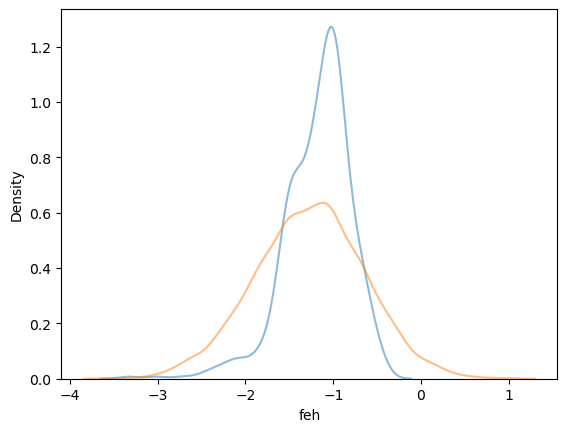

In [50]:
sns.kdeplot(true_data['feh'],  alpha=0.5, label='Simulation',)
sns.kdeplot(generated_data['feh'], alpha=0.5, label='Generated',);

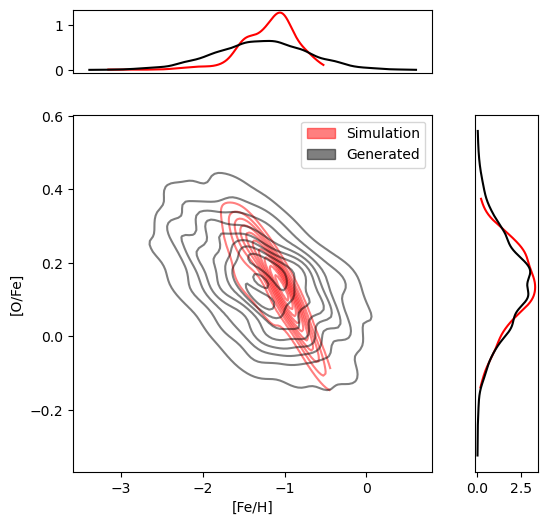

In [92]:
# Create a grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(6, 6), 
                    gridspec_kw={"height_ratios": (.15, .85), 
                                    "width_ratios": (.85, .15)})
ax[0, 1].remove()

colors = [['red'], ['black']]
patches = []

for i, data_type in enumerate(df_joinplot['Data'].unique()):
    # Assuming df_joinplot is your DataFrame
    x = df_joinplot['feh'][df_joinplot['Data'] == data_type]
    y = df_joinplot['ofe'][df_joinplot['Data'] == data_type]

    # # Scatter plot
    # ax[1, 0].scatter(x, y, label = data_type, alpha=0.5, s=1)
    # ax[1, 0].legend()
    # Calculate 2D KDE
    kde = gaussian_kde(np.vstack([x, y]))

    # Create a grid of points for which to evaluate the KDE
    x_d = np.linspace(min(x), max(x), 100)
    y_d = np.linspace(min(y), max(y), 100)
    X, Y = np.meshgrid(x_d, y_d)
    Z = kde.evaluate(np.vstack([X.ravel(), Y.ravel()]))

    # Plot 2D KDE
    contour = ax[1, 0].contour(X, Y, Z.reshape(X.shape), levels=10,  alpha=0.5, colors=colors[i])
    
    # Create a patch for the legend
    patches.append(mpatches.Patch(color=contour.collections[0].get_edgecolor(), label=data_type))
    
    # Calculate densities
    kde_x = gaussian_kde(x, )
    kde_y = gaussian_kde(y, )

    # Create an array of values for which to evaluate the KDE
    x_d = np.linspace(min(x), max(x), 1000)
    y_d = np.linspace(min(y), max(y), 1000)

    # Plot KDEs on the marginals
    ax[0, 0].plot(x_d, kde_x(x_d), color=colors[i][0])
    ax[1, 1].plot(kde_y(y_d), y_d, color=colors[i][0])

    # Remove labels from the marginal axes
    ax[0, 0].set_xticks([])
    ax[1, 1].set_yticks([])

    # Set labels on the joint plot
    ax[1, 0].set_xlabel('[Fe/H]')
    ax[1, 0].set_ylabel('[O/Fe]')
    
    # Add the legend
    ax[1, 0].legend(handles=patches)